In [1]:
import torch
import numpy as np
import normflows as nf

data_seed = 42
seed = 42
torch.manual_seed(seed)
torch.no_grad()
N=2**10

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.dirname(c_directory))
sys.path.append(os.path.join(os.path.dirname(c_directory), 'FCYeast'))
import FC3_simulator


from matplotlib import pyplot as plt
enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
target = FC3_simulator.target()
context_size = 6

latent_size = 1
hidden_units = 128
hidden_layers = 5



/home/pessoa/Codes/SBI-posterior/FCYeast3/FC3_simulator.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))
/home/pessoa/Codes/SBI-posterior/FCYeast3/FC3_simulator.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params_dist = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))


In [3]:
dils_str = ['12','23','33']
dils = [.12,.23,.33]
models=[]

for dil in dils_str:
    flows = [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 64,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 128,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 256,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),      
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 512,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size)
         ]
    model_file = 'dilution{}/FCYeast_network.pt'.format(dil)
    q0 = nf.distributions.DiagGaussian(1)
    model = nf.ConditionalNormalizingFlow(q0, flows, target)
    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.load_state_dict(torch.load(model_file))
    models.append(model)

In [4]:
X = np.loadtxt('FCYeast3_synth/synth_{}.csv'.format(data_seed)).astype(np.float32)
x = [torch.tensor(X[:,i]).reshape(-1,1).to(device)[:N] for i in range(3)]

In [5]:


def separate(x):
    return torch.tensor(((x[0],x[1],x[2],x[3],x[4],x[11]),
                         (x[0],x[1],x[5],x[6],x[7],x[11]),
                         (x[0],x[1],x[8],x[9],x[10],x[11]))).to(device)

to_hours = -torch.tensor(((0,0,-1,-1,1,0),
                         (0,0,-1,-1,1,0),
                         (0,0,-1,-1,1,0)),device=device)*torch.log(torch.tensor(dils)).reshape(-1,1).to(device)

def transform_to_hour(x): #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all in hours
    return separate(x) + to_hours


to_arbitrary = -torch.tensor(((1,1, 0, 0,0,0),
                             (1,1, 0, 0,0,0),
                             (1,1, 0, 0,0,0)),device=device)*torch.log(torch.tensor(dils)).reshape(-1,1).to(device)

def transform_to_arbitrary(x):  #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all to arbitrary
    return separate(x) + to_arbitrary

In [6]:
def logprior(params):
    return target.prior.log_prob(params)

vectorize_params = [torch.ones(xi.size(0),6).to(device) for xi in x]

def log_likelihood(data,params,models):
    global vectorize_params

    lp = []
    for (data_sub,params_sub,vec_params_sub,model_sub) in zip(data,params,vectorize_params,models):
        if data_sub.size !=  vec_params_sub.size(0):
            vec_params_sub = torch.ones((data_sub.size(0),6),device=device)
        lp.append(model_sub.log_prob(data_sub,params_sub*vec_params_sub))

    return lp

def log_post(data,params,models,lprior=logprior):
    return sum([lp.sum() for lp in log_likelihood(data,transform_to_arbitrary(params),models)]) + lprior(params)

In [7]:
gt = np.loadtxt('FCYeast3_synth/gt_map.csv').astype(np.float32)
gt = torch.tensor(gt[gt[:,0]==data_seed][0,1:],device=device)
gt

tensor([ 5.3367,  8.1288,  0.2345,  0.2303, -2.5807, -0.1863,  2.2082, -2.4595,
         0.4617,  0.2674, -2.1663,  1.6187], device='cuda:0')

In [8]:
log_post(x,gt,models)

tensor(-3649.0183, device='cuda:0')

In [9]:
params_100 = target.prior.sample((1000,))
best_param = params_100[0]
lp_max = log_post(x,best_param,models)

for par in params_100[1:]:
    lp_par = log_post(x,par,models)
    if lp_par>lp_max:
        best_param = par
        lp_max=lp_par
        print(best_param,lp_max)

for i in range(3,8):
    print(i)
    for par in (1/i)*(params_100-best_param) + best_param:
        lp_par = log_post(x,par,models)
        if lp_par>lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

tensor([ 3.4108,  8.6223,  1.6898, -0.6648, -2.0644,  0.0783,  0.0847, -2.3352,
         0.3316, -0.5890, -2.5681,  0.1908], device='cuda:0') tensor(-5810.8623, device='cuda:0')
tensor([ 5.5960e+00,  8.2322e+00,  1.1415e+00, -6.8171e-01, -2.7133e+00,
         6.0356e-03,  1.3815e+00, -1.9824e+00,  2.3238e-02, -1.3001e+00,
        -2.4877e+00,  7.5125e-01], device='cuda:0') tensor(-4466.1509, device='cuda:0')


tensor([ 4.6369,  8.0422, -1.2176, -0.5781, -2.2645, -0.4365,  0.9101, -2.2933,
        -0.5486, -1.1274, -1.8302,  1.9302], device='cuda:0') tensor(-4387.7539, device='cuda:0')
tensor([ 3.6323e+00,  8.5745e+00,  1.6706e+00,  1.1407e-03, -2.4640e+00,
         6.2146e-01,  1.7446e+00, -2.2287e+00, -1.4559e+00, -1.4933e+00,
        -2.6014e+00,  1.0185e+00], device='cuda:0') tensor(-4384.7798, device='cuda:0')
tensor([ 4.8619,  9.4128,  0.3494, -0.2839, -2.7003,  0.4856,  1.1777, -2.3510,
         0.6034, -0.3541, -2.5817, -0.0410], device='cuda:0') tensor(-4098.3848, device='cuda:0')
tensor([ 4.1424,  7.9789, -0.2818, -2.6927, -2.2849,  0.2153,  1.0075, -2.2343,
         0.9577, -1.5655, -2.3402,  1.1222], device='cuda:0') tensor(-4047.4512, device='cuda:0')
tensor([ 5.6949,  8.1096,  1.4594,  1.5853, -2.2977, -2.1526,  1.9863, -2.5133,
        -0.4451,  0.4818, -2.2917,  1.8727], device='cuda:0') tensor(-3934.3633, device='cuda:0')
3
tensor([ 5.5279,  8.7935,  0.9156,  1.3399, -2.4588,

In [10]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [11]:
S = torch.eye(12)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(12,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(12,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [12]:
count_of_safe=0
loopruns = 0

while count_of_safe <=15:
    for i in range(150):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,models)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-200:]).T.cov() + torch.eye(12)*1e-8) * (2.4**2/(12)) )
    loopruns+=1

    print(loopruns,acc_rate, '    ', sampled_logpost[-1])
    



1 0.66      -3658.930908203125


2 0.6      -3654.279296875
3 0.67      -3653.186279296875
4 0.53      -3650.380126953125
5 0.62      -3648.76953125
6 0.56      -3648.5283203125
7 0.49      -3647.25927734375
8 0.52      -3647.989501953125
9 0.55      -3651.3759765625
10 0.49      -3649.958251953125
11 0.44      -3652.631591796875
12 0.44      -3649.224853515625
13 0.47      -3652.27294921875
14 0.38      -3650.244140625
15 0.47      -3650.0478515625
16 0.45      -3651.992919921875
17 0.32      -3649.73486328125
18 0.46      -3651.21826171875
19 0.35      -3649.17529296875
20 0.44      -3647.3916015625
21 0.34      -3646.653564453125
22 0.35      -3649.26025390625
23 0.42      -3646.957763671875
24 0.47      -3647.348388671875
25 0.45      -3645.20947265625


In [13]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,models)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp)
        #print(i,param,lp)

99 tensor([ 6.0934,  8.7983, -0.0094, -0.1790, -2.0544, -0.3564,  2.2222, -2.6847,
         0.4509,  0.1075, -1.9349,  0.9029], device='cuda:0') tensor(-3648.2224, device='cuda:0')
199 tensor([ 5.6120,  8.2547,  0.2278,  0.0899, -1.9647, -0.4345,  2.1458, -2.5101,
         0.3349, -0.0763, -2.4260,  1.4564], device='cuda:0') tensor(-3651.3181, device='cuda:0')
299 tensor([ 6.1296,  8.8748,  0.0496,  0.0189, -2.2477, -0.4282,  2.1170, -2.6655,
         0.3455,  0.0514, -2.1788,  0.8379], device='cuda:0') tensor(-3647.3398, device='cuda:0')
399 tensor([ 5.9736,  8.8259,  0.0286, -0.1307, -2.0816, -0.3920,  1.9759, -2.1931,
         0.4450,  0.1377, -2.4584,  0.8510], device='cuda:0') tensor(-3649.7163, device='cuda:0')
499 tensor([ 6.1021,  8.7154, -0.0484, -0.4502, -2.2008, -0.4422,  1.9914, -2.5515,
         0.1638, -0.4200, -2.2437,  0.8984], device='cuda:0') tensor(-3646.3411, device='cuda:0')
599 tensor([ 5.9030e+00,  8.8523e+00, -4.1209e-03, -3.4996e-01, -1.9718e+00,
         5.283

In [14]:
np.savetxt('FC3_mcmc/results_{}seed_{}data_{}dp.csv'.format(seed,data_seed,N),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

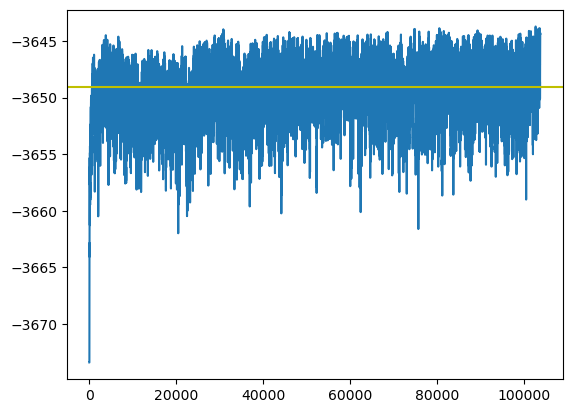

In [15]:
plt.plot(sampled_logpost)
plt.axhline(log_post(x,gt,models).cpu().numpy(),color='y')

In [16]:
#this still does a single n, please fix

def grid_plot(x,param,model):
    xp = torch.linspace(x.min(),x.max(),101).to(device)
    lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,6),device=device)*param)
    p = torch.exp(lp-lp.max())
    p *= 1/(p.sum()*(xp[1]-xp[0]))
    return xp.cpu(),p.cpu()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


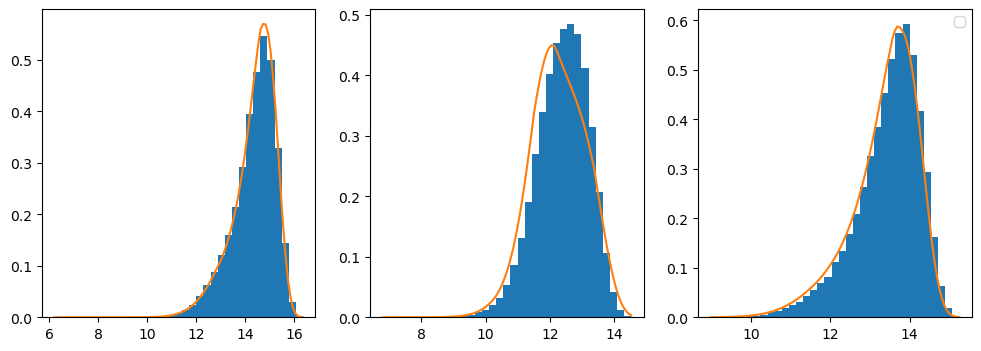

In [17]:
#x_all = X = np.loadtxt('FCYeast3_synth/synth_{}.csv'.format(data_seed)).astype(np.float32)
x_all = [torch.tensor(X[:,i]).reshape(-1,1).to(device)[:-1] for i in range(3)]
fig,ax = plt.subplots(1,3,figsize=(12,4))
[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x_all)]
params = transform_to_arbitrary(best_param)
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi) in zip(x_all,params,ax)]

x

plt.legend()